In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from scipy.special import spherical_jn

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = [12, 5.5]

from scipy.signal import savgol_filter

In [2]:
import camb
from camb import model, initialpower

(1551, 4)


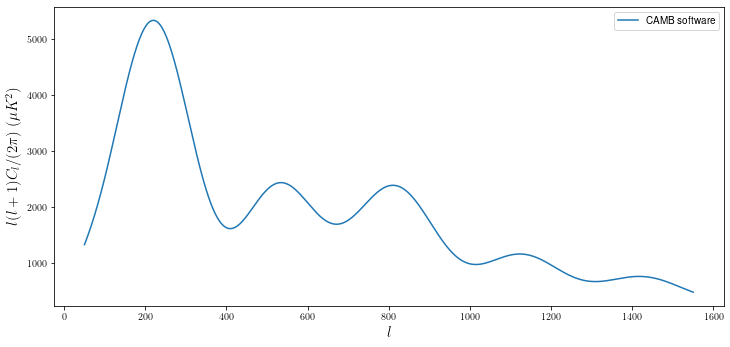

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(1500, lens_potential_accuracy=0);
#calculate results for these parameters
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
corr=totCL[:,0]
L = np.array(list(range(100,1500)))
#fx=np.array([C(l)/(2*np.pi) for l in L])
plt.plot(ls[50:], corr[50:], label="CAMB software")
plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Original.pdf', bbox_inches='tight')
plt.show()

No handles with labels found to put in legend.


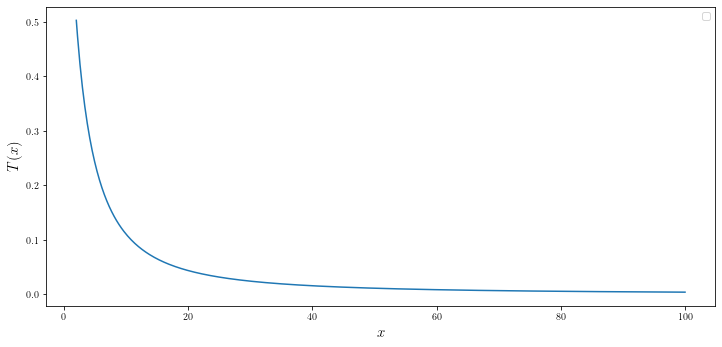

In [24]:
def P_R(k, ns):
    A_s=2.2
    k_0=0.05
    return A_s*(k/k_0)**(ns-1)

def R_gen(omega_b):
    def R(z):
        return omega_b*3.04E4/(1+z)
    return R

def T(x):
    aa=np.log(1+0.171*x)/(0.171*x)
    bb=1
    bb+=0.284*x
    bb+=(1.18*x)**2
    bb+=(0.399*x)**3
    bb+=(0.49*x)**4
    return aa*bb**(-0.25)

def c_s_sq(z, omega_b):
    R=R_gen(omega_b)
    return 1/(3*(1+R(z)))

def c_s(z,omega_b):
    return c_s_sq(z,omega_b)

def j_l_sq_gen(l):
    def j_l_sq(x):
        return 0 if x<=l else 1/(2*x*np.sqrt(x**2-l**2))
    return j_l_sq

def E_gen(omega_m, h):
    omega_r=4.17E-5 
    omega_Lambda=h**2-omega_r-omega_m
    def E(z):
        return 1/h*(omega_m*(1+z)**3+omega_r*(1+z)**4+omega_Lambda)**0.5
    return E

def r_s(h,omega_m, z_dec, omega_b):
    E=E_gen(omega_m,h)
    integrando=lambda z: np.sqrt(c_s(z, omega_b))/E(z)
    integral=quad(integrando, z_dec, np.inf, limit=1000)[0]
    H_0_inv=2998/h
    return H_0_inv*integral 

xs=np.linspace(2,100,num=500)
plt.plot(xs,[T(x) for x in xs])
#plt.plot(ls[100:], (corr/2300)[100:], label="CAMB software")
#plt.plot(ls[100:], corr[100:], label="CAMB software")
plt.title("",fontsize = 15)
plt.xlabel("$x$",fontsize = 15)
plt.ylabel("$T(x)$",fontsize = 15)
plt.legend(loc=1)
savefig('T.pdf', bbox_inches='tight')
plt.show()

In [5]:
def plotfn(f):
    ks=np.linspace(0,0.1, num=500)
    plt.plot(ks,np.array([f(k) for k in ks]), label="Our calculations")
    plt.show()

def C_gen(h,omega_b,omega_m, ns, fixR_z_dec=1, fixDeltaEta=1, fixRs=1):
    z_dec=1090; k_eq=0.073*omega_m
    r_s_cte=r_s(h, omega_m, z_dec, omega_b)
    r_s_cte*=fixRs
    R=R_gen(omega_b)
    E=E_gen(omega_m,h)
    DeltaEta=2998/h*quad(lambda z: 1/E(z),0,z_dec,limit=1000)[0]
    R_z_dec=R(z_dec); k_D=0.14
    R_z_dec*=fixR_z_dec
    DeltaEta*=fixDeltaEta
    print("R(z_dec):{}, r_s:{}, d^c_a(z_dec):{}".format(R_z_dec,r_s_cte,DeltaEta))
    def C(l):
        j_l_sq=j_l_sq_gen(l) 
        prefactor=4*np.pi*9/25
        def integrando(k):
            ret = P_R(k, ns)
            ret*=j_l_sq(k*DeltaEta)
            #ret*=spherical_jn(l,k*DeltaEta)**2
            #ret*=spherical_jn(l,k*DeltaEta)
            ret*=(-R_z_dec*T(k/k_eq) + 5/3*np.cos(k*r_s_cte)*np.exp(-k**2/k_D**2) )**2
            return ret/k
        integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )
        #print(err)
        #if l==500:
            #plotfn(integrando)
        return 2730*prefactor*integ
    return C

R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095


No handles with labels found to put in legend.


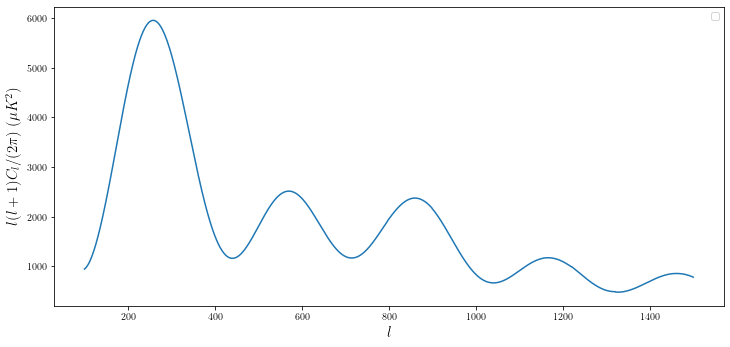

In [6]:
C=C_gen(0.67,0.022,0.14,0.97)
L = np.array(list(range(100,1500)))
vC=np.vectorize(C)
fx=L*(L+1)*vC(L)/(2*np.pi)
#fx=np.array([C(l)/(2*np.pi) for l in L])
fxsmooth=savgol_filter(fx, 51, 3)
fx=savgol_filter(fx, 101, 3)
plt.plot(L,fx)
#plt.plot(ls[100:], (corr/2300)[100:], label="CAMB software")
#plt.plot(ls[100:], corr[100:], label="CAMB software")
plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado1.pdf', bbox_inches='tight')
plt.show()

In [21]:
print([np.pi*m*14002.412983316095/145.3533418037435 for m in range(1,4)])

[302.64097966396565, 605.2819593279313, 907.9229389918969]


<ipython-input-24-4d4004727560>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return A_s*(k/k_0)**(ns-1)
<ipython-input-24-4d4004727560>:12: RuntimeWarning: invalid value encountered in double_scalars
  aa=np.log(1+0.171*x)/(0.171*x)
<ipython-input-24-4d4004727560>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return A_s*(k/k_0)**(ns-1)
<ipython-input-24-4d4004727560>:12: RuntimeWarning: invalid value encountered in double_scalars
  aa=np.log(1+0.171*x)/(0.171*x)
No handles with labels found to put in legend.


R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095


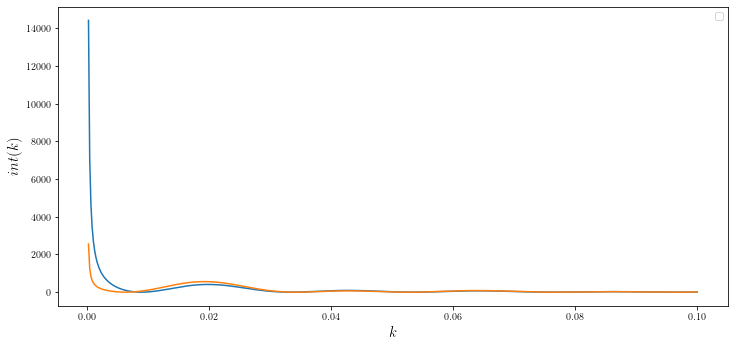

In [28]:
def C_genIntegrando(h,omega_b,omega_m, ns, fixR_z_dec=1, fixDeltaEta=1, fixRs=1):
    z_dec=1090; k_eq=0.073*omega_m
    r_s_cte=r_s(h, omega_m, z_dec, omega_b)
    r_s_cte*=fixRs
    R=R_gen(omega_b)
    E=E_gen(omega_m,h)
    DeltaEta=2998/h*quad(lambda z: 1/E(z),0,z_dec,limit=1000)[0]
    R_z_dec=R(z_dec); k_D=0.14
    R_z_dec*=fixR_z_dec
    DeltaEta*=fixDeltaEta
    print("R(z_dec):{}, r_s:{}, d^c_a(z_dec):{}".format(R_z_dec,r_s_cte,DeltaEta))
    prefactor=4*np.pi*9/25
    def integrando(k):
        ret = P_R(k, ns)
        #ret*=spherical_jn(l,k*DeltaEta)**2
        #ret*=spherical_jn(l,k*DeltaEta)
        ret*=(-R_z_dec*T(k/k_eq) + 5/3*np.cos(k*r_s_cte)*np.exp(-k**2/k_D**2) )**2
        return ret/k
        #print(err)
        #if l==500:
            #plotfn(integrando)
    return integrando
def C_genIntegrando2(h,omega_b,omega_m, ns, fixR_z_dec=1, fixDeltaEta=1, fixRs=1):
    z_dec=1090; k_eq=0.073*omega_m
    r_s_cte=r_s(h, omega_m, z_dec, omega_b)
    r_s_cte*=fixRs
    R=R_gen(omega_b)
    E=E_gen(omega_m,h)
    DeltaEta=2998/h*quad(lambda z: 1/E(z),0,z_dec,limit=1000)[0]
    R_z_dec=R(z_dec); k_D=0.14
    R_z_dec*=fixR_z_dec
    DeltaEta*=fixDeltaEta
    print("R(z_dec):{}, r_s:{}, d^c_a(z_dec):{}".format(R_z_dec,r_s_cte,DeltaEta))
    prefactor=4*np.pi*9/25
    def integrando(k):
        ret = P_R(k, ns)
        #ret*=spherical_jn(l,k*DeltaEta)**2
        #ret*=spherical_jn(l,k*DeltaEta)
        ret*=(-R_z_dec*2*T(k/k_eq) + 5/3*np.cos(k*r_s_cte)*np.exp(-k**2/k_D**2) )**2
        return ret/k
        #print(err)
        #if l==500:
            #plotfn(integrando)
    return integrando
f=C_genIntegrando(0.67,0.022,0.14,0.97)
f2=C_genIntegrando2(0.67,0.022,0.14,0.97)
ks=np.linspace(0,0.1,num=500)
plt.plot(ks,[f(k) for k in ks])
plt.plot(ks,[f2(k) for k in ks])
#plt.plot(ls[100:], (corr/2300)[100:], label="CAMB software")
#plt.plot(ls[100:], corr[100:], label="CAMB software")
plt.title("",fontsize = 15)
plt.xlabel("$k$",fontsize = 15)
plt.ylabel("$int(k)$",fontsize = 15)
plt.legend(loc=1)
savefig('integrando.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.3065077910174152, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):1.2260311640696608, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095


<ipython-input-5-6c6c95332940>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )


R(z_dec):1.8390467461044913, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095


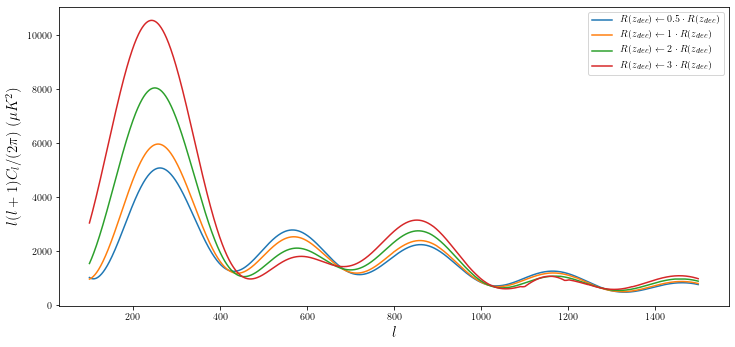

In [7]:
for c in [0.5,1,2,3]:
    C=C_gen(0.67,0.022,0.14,0.97, fixR_z_dec=c)
    vC=np.vectorize(C)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$R(z_{{dec}})\leftarrow {}\cdot R(z_{{dec}})$".format(c))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado2.1.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.6130155820348304, r_s:130.81800762336914, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:159.88867598411784, d^c_a(z_dec):14002.412983316095


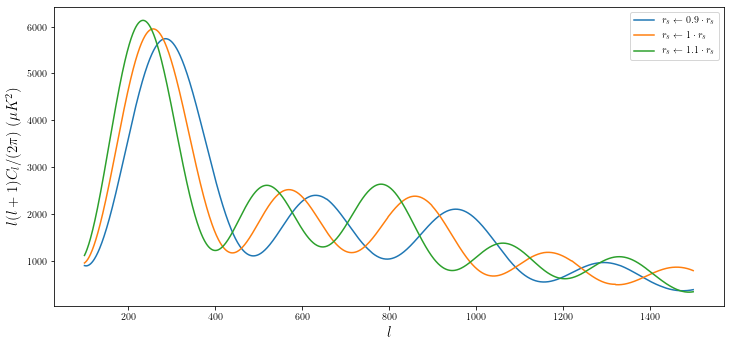

In [8]:
for c in [0.9,1,1.1]:
    C=C_gen(0.67,0.022,0.14,0.97, fixRs=c)
    vC=np.vectorize(C)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$r_s\leftarrow {}\cdot r_s$".format(c))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado2.2.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):10501.80973748707


<ipython-input-5-6c6c95332940>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )


R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):17503.01622914512


<ipython-input-5-6c6c95332940>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )


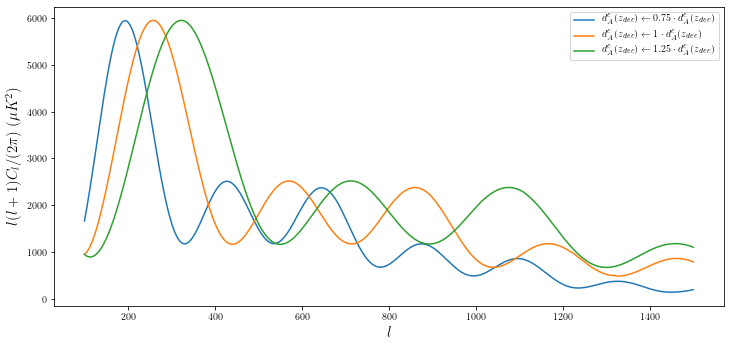

In [9]:
for c in [0.75,1,1.25]:
    C=C_gen(0.67,0.022,0.14,0.97, fixDeltaEta=c)
    vC=np.vectorize(C)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$d_A^c(z_{{dec}})\leftarrow {}\cdot d_A^c(z_{{dec}})$".format(c))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado2.3.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.6130155820348304, r_s:145.35334181419296, d^c_a(z_dec):14770.59102227263
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.35334179370383, d^c_a(z_dec):13512.752041631249


<ipython-input-5-6c6c95332940>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )


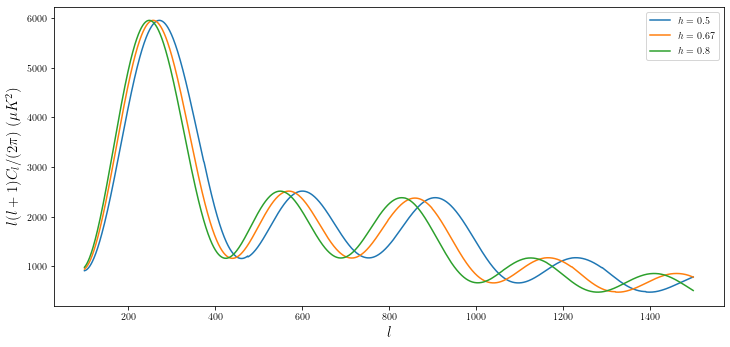

In [10]:
for h in [0.5,0.67,0.8]:
    C=C_gen(h,0.022,0.14,0.97)
    vC=np.vectorize(C)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$h={}$".format(h))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado3.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.27864344637946836, r_s:153.82680820882229, d^c_a(z_dec):14002.412983316095
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
R(z_dec):1.1145737855178734, r_s:135.49964148900244, d^c_a(z_dec):14002.412983316095


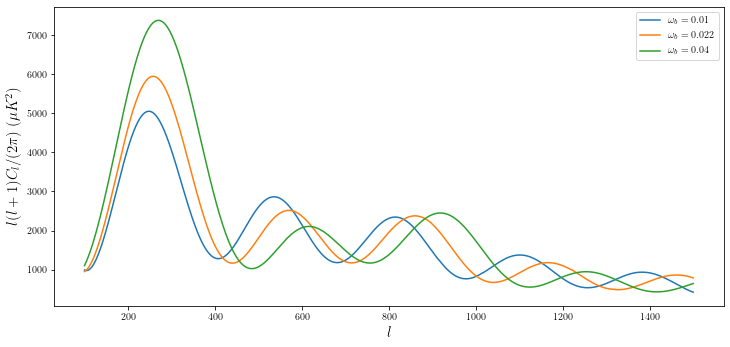

In [11]:
for wb in [0.01,0.022,0.04]:
    C=C_gen(0.67,wb,0.14,0.97)
    vC=np.vectorize(C)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$\omega_b={}$".format(wb))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado4.pdf', bbox_inches='tight')
plt.show()

R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
[ 100  101  102 ... 1497 1498 1499]


<ipython-input-5-6c6c95332940>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integ, err = quad(integrando,l/DeltaEta,np.inf, limit=1000 )


R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
[ 100  101  102 ... 1497 1498 1499]
R(z_dec):0.6130155820348304, r_s:145.3533418037435, d^c_a(z_dec):14002.412983316095
[ 100  101  102 ... 1497 1498 1499]


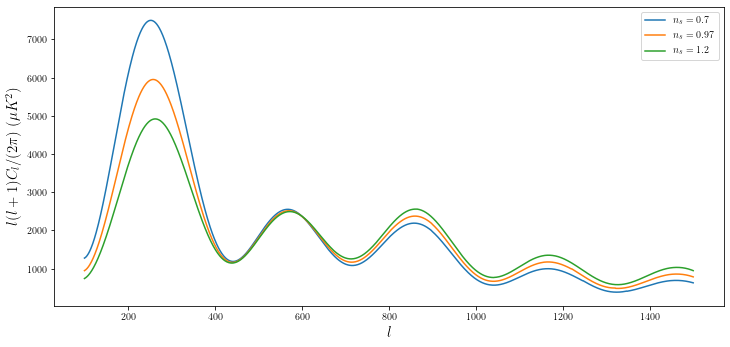

In [12]:
for ns in [0.7,0.97,1.2]:
    C=C_gen(0.67,0.022,0.14,ns)
    vC=np.vectorize(C)
    print(L)
    fx=L*(L+1)*vC(L)/(2*np.pi)
    fx=savgol_filter(fx, 101, 3)
    plt.plot(L,fx, label="$n_s={}$".format(ns))

plt.title("",fontsize = 15)
plt.xlabel("$l$",fontsize = 15)
plt.ylabel("$l(l+1)C_l/(2\pi)\ (\mu K^2)$",fontsize = 15)
plt.legend(loc=1)
savefig('Apartado5.pdf', bbox_inches='tight')
plt.show()

In [13]:
l=14002.412983316095*0.05
print("Multipolo para k_0: {}".format(l))

Multipolo para k_0: 700.1206491658048
